# Resizing Images 

In [1]:
from tqdm import tqdm
import glob
import cv2
import os

#pretrainedmodels.model_names

In [2]:
def resize_image(inp_path, saving_path, loc_len):
    
    
    for img_path in tqdm(glob.glob(inp_path)[:]):
        
        
        image_name =  img_path[loc_len:] 

        img = cv2.imread(img_path)
        

        width = int(128)
        height = int(128)
        dim = (width, height)
        
        # resize image
        resized_img = cv2.resize(img, dim)
 

        cv2.imwrite(os.path.join(saving_path, image_name), resized_img)       

In [3]:
inp_path = '/home/harsh/amk/quality_check_dataset/Test/Bad Quality/*'
saving_path = r'/home/harsh/amk/64*64_Resized_imgs_of_good_bad/Test/Bad Quality/'
loc_len = 55
resize_image(inp_path, saving_path, loc_len)

100%|██████████| 950/950 [01:06<00:00, 14.32it/s]


In [4]:
inp_path = '/home/harsh/amk/quality_check_dataset/Train/Good Quality/*'
saving_path = r'/home/harsh/amk/64*64_Resized_imgs_of_good_bad/Train/Good Quality/'
loc_len = 57
resize_image(inp_path, saving_path, loc_len)

100%|██████████| 6997/6997 [11:09<00:00, 10.45it/s]


In [5]:
inp_path = '/home/harsh/amk/quality_check_dataset/Train/Bad Quality/*'
saving_path = r'/home/harsh/amk/64*64_Resized_imgs_of_good_bad/Train/Bad Quality/'
loc_len = 56
resize_image(inp_path, saving_path, loc_len)

100%|██████████| 5174/5174 [06:33<00:00, 13.14it/s]


In [6]:
inp_path = '/home/harsh/amk/quality_check_dataset/Test/Good Quality/*'
saving_path = r'/home/harsh/amk/64*64_Resized_imgs_of_good_bad/Test/Good Quality/'
loc_len = 56
resize_image(inp_path, saving_path, loc_len)

100%|██████████| 950/950 [01:08<00:00, 13.95it/s]


# Delete the Resized Images as per folder

In [42]:
def delete_resized_img(do_you_want_run):
    if do_you_want_run == False:
        return 
        
    for f in glob.glob('/home/harsh/amk/Resized_imgs_of_good_bad/Train/Bad Quality/*'):
        os.remove(f)
    
    for f in glob.glob('/home/harsh/amk/Resized_imgs_of_good_bad/Train/Good Quality/*'):
        os.remove(f)
        
    for f in glob.glob('/home/harsh/amk/Resized_imgs_of_good_bad/Test/Good Quality/*'):
        os.remove(f)
    
    for f in glob.glob('/home/harsh/amk/Resized_imgs_of_good_bad/Test/Bad Quality/*'):
        os.remove(f)
        
delete_resized_img(do_you_want_run = True)
        

# resnet18

In [3]:
def cadene_model(model_name):
    def my_model(pretrained = True, **kwargs):
        return pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
    return my_model

In [4]:
model = cadene_model("resnet34")
learn = cnn_learner(data, model, pretrained = True, callback_fns=ShowGraph, \
                         metrics=[error_rate, accuracy, AUROC(), Recall(), \
                         Precision(),MatthewsCorreff()])

NameError: name 'data' is not defined

# Deep Learning

In [1]:
from tqdm import tqdm
import glob
import cv2
import os
from fastai.vision import *
from fastai.vision.models import *
import python_utils
from utils import *
import torch
import pretrainedmodels.utils as utils 
from torchvision import models
import torch
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import pretrainedmodels
#pretrainedmodels.model_names

In [2]:
#dir(models)

In [167]:
pole_path_dir = '/home/harsh/amk/Resized_imgs_of_good_bad/'
pole_path = Path(pole_path_dir)


In [172]:
data =  ImageDataBunch.from_folder(pole_path, train = 'Train', test = 'Test', 
                                         valid_pct=0.2, \
                                         #ds_tfms=get_transforms(), \
                                         size = (128,128), \
                                         bs = 10, num_workers=4).normalize(imagenet_stats)

In [173]:
rn18_learn = cnn_learner(data, models.resnet18, callback_fns=ShowGraph, \
                         metrics=[error_rate, accuracy, AUROC(), Recall(), \
                         Precision(),MatthewsCorreff()])

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,recall,precision,matthews_correff,time
0,0.093650,0.124634,0.037082,0.962918,0.991968,0.985263,0.952510,0.924133,00:17
1,0.092438,0.140177,0.040750,0.959250,0.991430,0.987368,0.944929,0.916931,00:17
2,0.119427,0.134788,0.037490,0.962510,0.990355,0.971228,0.964460,0.922944,00:17
3,0.108767,0.108257,0.035860,0.964140,0.992349,0.977544,0.961353,0.926311,00:17
4,0.117704,0.109558,0.038712,0.961288,0.991901,0.969825,0.963738,0.920435,00:17
5,0.129979,0.224196,0.038712,0.961288,0.985607,0.969825,0.963738,0.920435,00:17
6,0.139614,0.105323,0.035452,0.964548,0.992442,0.974035,0.965230,0.927127,00:17


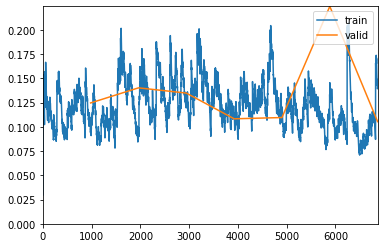

Better model found at epoch 0 with auroc value: 0.9919683933258057.
Better model found at epoch 3 with auroc value: 0.992348849773407.
Better model found at epoch 6 with auroc value: 0.9924423098564148.


In [176]:
defaults.device = torch.device('cuda') #makes sure the gpu is used
rn18_learn.fit_one_cycle(7, callbacks = callbacks.SaveModelCallback(rn18_learn,monitor='auroc',mode='max'))

# Testing Images with databunch

In [5]:
rn18_learn = load_learner("/home/harsh/amk/Resized_imgs_of_good_bad/", 'Image_Quality_Classifier.pkl')

In [177]:
preds, _= rn18_learn.get_preds(ds_type=DatasetType.Test)

pred = torch.max(preds, dim = -1)

pred_probability = pred.values.numpy()
pred_label = pred.indices.numpy()

df_result = pd.DataFrame(columns = [ 'Actual', 'Predicted', "Probability on Prediction Class", \
                                    "Probability on Actual Class", 'Image Path'])
tn = 0
tp = 0
fp = 0
fn = 0
y_test = []

for i, img_path in enumerate(tqdm(data.test_ds.items)):
    df_result.loc[i, 'Image Path'] = img_path
    df_result.loc[i, 'Probability on Prediction Class'] = pred_probability[i]
    if str(img_path)[46:58] == 'Good Quality':
        y_test.append(1)
        df_result.loc[i, 'Probability on Actual Class'] = preds.numpy()[i][1]
        df_result.loc[i, 'Actual'] = "Good Quality"
        if pred_label[i] == 1:
            df_result.loc[i, 'Predicted'] = "Good Quality"
            tp +=1
        else: 
            df_result.loc[i, 'Predicted'] = "Bad Quality"
            fn += 1
        
    else: 
        y_test.append(0)
        df_result.loc[i, 'Probability on Actual Class'] = preds.numpy()[i][0]
        df_result.loc[i, 'Actual'] = "Bad Quality"
        if pred_label[i] == 0 :
            df_result.loc[i, 'Predicted'] = "Bad Quality"
            tn += 1
        else :    
            df_result.loc[i, 'Predicted'] = "Good Quality"
            tp += 1
        

100%|██████████| 1800/1800 [00:02<00:00, 624.48it/s]


In [178]:
df_result

,Actual,Predicted,Probability on Prediction Class,Probability on Actual Class,Image Path
0,Good Quality,Good Quality,1,1,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...
1,Good Quality,Good Quality,0.996031,0.996031,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...
2,Good Quality,Good Quality,1,1,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...
3,Good Quality,Good Quality,1,1,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...
4,Good Quality,Good Quality,1,1,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...
...,...,...,...,...,...
1795,Bad Quality,Bad Quality,0.992945,0.992945,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...
1796,Bad Quality,Bad Quality,0.999694,0.999694,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...
1797,Bad Quality,Bad Quality,0.990375,0.990375,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...
1798,Bad Quality,Bad Quality,0.999667,0.999667,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...


In [179]:
wrong_predicted = df_result[df_result["Actual"] != df_result["Predicted"]]

In [180]:
wrong_predicted

,Actual,Predicted,Probability on Prediction Class,Probability on Actual Class,Image Path
87,Good Quality,Bad Quality,0.652542,0.347458,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...
102,Good Quality,Bad Quality,0.800992,0.199008,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...
108,Good Quality,Bad Quality,0.583508,0.416492,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...
114,Good Quality,Bad Quality,0.630854,0.369146,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...
124,Good Quality,Bad Quality,0.553371,0.446629,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...
141,Good Quality,Bad Quality,0.746649,0.253351,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...
183,Good Quality,Bad Quality,0.757441,0.242559,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...
192,Good Quality,Bad Quality,0.951023,0.0489769,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...
207,Good Quality,Bad Quality,0.644355,0.355645,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...
340,Good Quality,Bad Quality,0.897185,0.102815,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...


In [181]:
len(wrong_predicted["Actual"])

23

In [182]:
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)

In [183]:
print("Specificity on Test data", specificity)
print("Sensitivity on Test data", sensitivity)

Specificity on Test data 1.0
Sensitivity on Test data 0.9755826859045506


In [188]:
precision = tp / (tp + fp)

In [189]:
print("Precision on Test data", precision)

Precision on Test data 1.0


In [190]:
F1_score = 2*(sensitivity * precision)/ (sensitivity + precision)

In [191]:
print("F1 score  on Test data", F1_score)

F1 score  on Test data 0.9876404494382022


In [192]:
mcc = ((tp*tn) - (fp*fn)) / np.sqrt( (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn) )

In [193]:
print(" Matthews Correlation Coefficient  on Test data", mcc)

 Matthews Correlation Coefficient  on Test data 0.9758477673080128


In [184]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label="Test Auc = "+str(auc))
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate or (1-Specificity)')
    plt.ylabel('True Positive Rate or Recall or Sensitivity')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [185]:
auc = roc_auc_score(y_test, preds[:, 1])
print('AUC: %.2f' % auc)

AUC: 1.00


In [31]:
fpr, tpr, thresholds = roc_curve(y_test,preds[:, 1] )

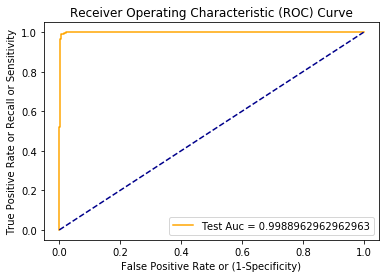

In [32]:
plot_roc_curve(fpr, tpr)

# Image check one by one

100%|██████████| 50/50 [00:00<00:00, 215.67it/s]


In [34]:
wrong_count

0

# Prediction on single image

In [57]:
# Saving Model
#rn18_learn.export('Image_Quality_Classifier_ImgSize_128_ResNet18_auroc_99.60_Recall_98_Precision_97_MathewsCoeff_94_with_ImagenetStatsNormalization.pkl', destroy=False)

In [58]:
learn = load_learner("/home/harsh/amk/Resized_imgs_of_good_bad/", 'Image_Quality_Classifier_ImgSize_128_ResNet18_auroc_99.60_Recall_98_Precision_97_MathewsCoeff_94_with_ImagenetStatsNormalization.pkl')

In [69]:
img = open_image('/home/harsh/amk/Resized_imgs_of_good_bad/Hand_Test/Good Quality/after.jpeg')

In [70]:
result = learn.predict(img)

In [71]:
(print("This image is of",result[0],"and probability of prediction is ", result[2].numpy().max()))

This image is of Good Quality and probability of prediction is  0.8678467


# Prediction on Multiple Images

In [2]:
learn = load_learner("/home/harsh/amk/Resized_imgs_of_good_bad/", 'Image_Quality_Classifier_ImgSize_128_ResNet18_auroc_99.60_Recall_98_Precision_97_MathewsCoeff_94_with_ImagenetStatsNormalization.pkl')

In [16]:
learn = rn18_learn

In [21]:
result_of_pred = []
for img_path in tqdm(glob.glob('/home/harsh/Harsh/small_dataset_25000/Images/*')[6000:7000]):
    img = open_image(img_path)
    result = learn.predict(img)
    result_of_pred.append(str(result[0]))
    
    if str(result[0]) == "Good Quality":
        shutil.copy(img_path, '/home/harsh/amk/good_bad_imgs_by_classifier/Good Quality/')
    else: 
        shutil.copy(img_path, '/home/harsh/amk/good_bad_imgs_by_classifier/Bad Quality/')
     
    

100%|██████████| 1000/1000 [00:11<00:00, 85.90it/s]


In [22]:
total_good_imgs = 0
total_bad_imgs = 0
good_idx = []
bad_idx = []
for idx, val in enumerate(result_of_pred):
    if str(val) == 'Good Quality':
        total_good_imgs += 1
        good_idx.append(idx)
        
    else:
        total_bad_imgs += 1
        bad_idx.append(idx)

In [23]:
(total_good_imgs/(total_bad_imgs+total_good_imgs))*100

80.4

In [25]:
img = open_image('/home/harsh/amk/Resized_imgs_of_good_bad/Hand_Test/Good Quality/after.jpeg')

In [26]:
result = learn.predict(img)

In [35]:
result[2].numpy()[1]

0.1321533

In [14]:
good_img_path = '/home/harsh/amk/Resized_imgs_of_good_bad/Test/Good Quality/*'
bad_img_path = '/home/harsh/amk/Resized_imgs_of_good_bad/Test/Bad Quality/*'

In [15]:


df_result = pd.DataFrame(columns = [ 'Actual', 'Predicted', "Probability on Prediction Class", \
                                    "Probability on Actual Class", 'Image Path'])


for i, img_path in enumerate(tqdm(glob.glob(good_img_path) + glob.glob(bad_img_path) )):
    df_result.loc[i, 'Image Path'] = img_path
    img = open_image(img_path)
    result = learn.predict(img)
    
    if i < len(glob.glob(good_img_path)):
        df_result.loc[i, 'Actual'] = 'Good Quality'
        df_result.loc[i, 'Predicted'] = str(result[0])
        df_result.loc[i, 'Probability on Prediction Class'] = max(result[2].numpy())
    else:
        df_result.loc[i, 'Actual'] = 'Bad Quality'
        df_result.loc[i, 'Predicted'] = str(result[0])
        df_result.loc[i, 'Probability on Prediction Class'] = max(result[2].numpy())
        

100%|██████████| 1800/1800 [00:18<00:00, 96.40it/s] 


# Prediction on 25k Dataset

In [19]:


df_good_imgs_result = pd.DataFrame(columns = [ 'Actual', 'Predicted', "Probability on Prediction Class", \
                                     'Image Path'])
df_bad_imgs_result = pd.DataFrame(columns = [ 'Actual', 'Predicted', "Probability on Prediction Class", \
                                     'Image Path'])

for i, img_path in enumerate(tqdm(glob.glob('/home/harsh/amk/25k_Images/*'))):
    
    img = open_image(img_path)
    result = learn.predict(img)
    
    if str(result[0]) == 'Good Quality':
        shutil.copy(img_path, '/home/harsh/amk/25k_images_Prediction_Result/Good Quality/')                     
        df_good_imgs_result.loc[i, 'Image Path'] = img_path
        df_good_imgs_result.loc[i, 'Predicted'] = str(result[0])
        df_good_imgs_result.loc[i, 'Probability on Prediction Class'] = max(result[2].numpy())
        
    else:
        shutil.copy(img_path, '/home/harsh/amk/25k_images_Prediction_Result/Bad Quality/')                     
        df_bad_imgs_result.loc[i, 'Image Path'] = img_path
        df_bad_imgs_result.loc[i, 'Predicted'] = str(result[0])
        df_bad_imgs_result.loc[i, 'Probability on Prediction Class'] = max(result[2].numpy())
        

100%|██████████| 21330/21330 [06:20<00:00, 56.03it/s]


# Hand Prediction of Good Images and copy images which is really doubtfull

In [2]:
import shutil
import os
itr = 0
for i, img_path in enumerate(tqdm(glob.glob('/home/harsh/amk/25k_images_Prediction_Result/Good Quality/*')[8882:])):
    #saving iteration number
    itr = i
    
    img = cv2.imread(img_path)
    #imS = cv2.resize(img, (512, 512)) 
    
    cv2.imshow("Images ", img)
    key = cv2.waitKey(0)
    # press b for Bad cases
    if key == 98:
        shutil.move(img_path, '/home/harsh/amk/DoubtFull_25k_Image/Good Quality/')
        
    # press n for Normal cases    
    if key == 110:
        shutil.move(img_path, '/home/harsh/amk/DoubtFull_25k_Image/Not Doubtfull Good Quality/')
    
    # press s for Subtle cases    
    if key == 115:
        shutil.move(img_path, '/home/harsh/amk/DoubtFull_25k_Image/Not Doubtfull Good Quality/')
        
    # press l to out from loop or break this image showing loop
    if key == 108:
        cv2.destroyAllWindows()
        break
    cv2.destroyAllWindows()
    
     
    
    

100%|██████████| 8045/8045 [3:05:08<00:00,  1.38s/it]   


itr

# Hand Prediction of Bad Images and copy images which is really doubtfull

In [3]:
for i, img_path in enumerate(tqdm(glob.glob('/home/harsh/amk/25k_images_Prediction_Result/Bad Quality/*')[:])):
    
    img = cv2.imread(img_path)
    #imS = cv2.resize(img, (512, 512)) 
    
    cv2.imshow("Images ", img)
    key = cv2.waitKey(0)
    # press m for doubtfull cases
    if key == 109:
        shutil.copy(img_path, '/home/harsh/amk/DoubtFull_25k_Image/Bad Quality/')
        
    # press n for Not doubtfull cases    
    if key == 110:
        shutil.copy(img_path, '/home/harsh/amk/DoubtFull_25k_Image/Not Doubtfull Bad Quality/')    
        
    # press l to out from loop
    if key == 108:
        cv2.destroyAllWindows()
        break
    cv2.destroyAllWindows()

100%|██████████| 4403/4403 [1:26:18<00:00,  1.18s/it]    


In [5]:
df_result

,Actual,Predicted,Probability on Prediction Class,Probability on Actual Class,Image Path
0,Good Quality,Good Quality,0.999999,NaN,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...
1,Good Quality,Good Quality,0.999599,NaN,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...
2,Good Quality,Good Quality,0.999493,NaN,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...
3,Good Quality,Good Quality,1,NaN,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...
4,Good Quality,Good Quality,1,NaN,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...
...,...,...,...,...,...
1795,Bad Quality,Bad Quality,0.999972,NaN,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...
1796,Bad Quality,Bad Quality,0.999872,NaN,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...
1797,Bad Quality,Bad Quality,0.99991,NaN,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...
1798,Bad Quality,Bad Quality,0.999568,NaN,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...


In [9]:
DoubtFull_Prediction = df_result[(df_result["Predicted"] == 'Good Quality') & 
                                 (df_result["Probability on Prediction Class"] < 1)&
                                 (df_result["Probability on Prediction Class"] > .9950)
                                ]


In [10]:
DoubtFull_Prediction

,Actual,Predicted,Probability on Prediction Class,Probability on Actual Class,Image Path
0,Good Quality,Good Quality,0.999999,NaN,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...
1,Good Quality,Good Quality,0.999599,NaN,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...
2,Good Quality,Good Quality,0.999493,NaN,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...
5,Good Quality,Good Quality,0.999974,NaN,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...
7,Good Quality,Good Quality,0.996848,NaN,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...
...,...,...,...,...,...
889,Good Quality,Good Quality,0.999992,NaN,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...
892,Good Quality,Good Quality,0.999479,NaN,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...
893,Good Quality,Good Quality,1,NaN,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...
896,Good Quality,Good Quality,0.999979,NaN,/home/harsh/amk/Resized_imgs_of_good_bad/Test/...


In [13]:
if DEVI^SMT^TETARI_20161026132442157201005001.png in (glob.glob(good_img_path) + glob.glob(bad_img_path)):
    print

'/home/harsh/amk/Resized_imgs_of_good_bad/Test/Good Quality/ARMD R KARHTI KRISHNAN_K_01-01-1938_0366_(0009).jpg'

In [85]:
src_path = '/home/harsh/amk/disease/Valid/CHOROIDITIS/*'
des_path = '/home/harsh/amk/prepro_disease/Valid/CHOROIDITIS/'

prepro_imgs(src_path, des_path)

100%|██████████| 344/344 [00:04<00:00, 84.96it/s]


In [64]:
total_bad_imgs/(total_bad_imgs+total_good_imgs)

1.0

In [76]:
str(result_of_pred[10])

'Good Quality'

In [ ]:
wrong_predicted_img = cv2.imread(str(wrong_predicted.iloc[18, -1]))
cv2.imshow("Wrong Predicted Images ", wrong_predicted_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [143]:
wrong_predicted.iloc[0, -1]

PosixPath('/home/harsh/amk/Resized_imgs_of_good_bad/Test/Good Quality/^RIYAJUDIN_20170105120825164001004001.png')

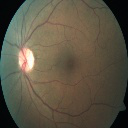

In [79]:
data.test_ds.x[3]

In [55]:
rs18_learn.save("rs18_model")

In [56]:
rs18_learn.load("rs18_model")

Learner(data=ImageDataBunch;

Train: LabelList (9737 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Good Quality,Good Quality,Good Quality,Good Quality,Good Quality
Path: /home/harsh/amk/Resized_imgs_of_good_bad;

Valid: LabelList (2434 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Good Quality,Bad Quality,Good Quality,Bad Quality,Good Quality
Path: /home/harsh/amk/Resized_imgs_of_good_bad;

Test: LabelList (1900 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: /home/harsh/amk/Resized_imgs_of_good_bad, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation

In [30]:
interp = ClassificationInterpretation.from_learner(rs18_learn)
#interp.plot_top_losses()

In [31]:
interp.confusion_matrix()

array([[1022,   69],
       [  73, 1270]])

In [46]:
interp = ClassificationInterpretation.from_learner(rs18_learn,ds_type= DatasetType.Test)

In [6]:
pole_path_dir = '/home/harsh/amk/Resized_imgs_of_good_bad/'
pole_path = Path(pole_path_dir)


# Data Augmentation

In [120]:
tfms = get_transforms(do_flip = True, max_rotate=10)
len(tfms)


2

In [121]:
def get_ex(): return open_image('/home/harsh/amk/Resized_imgs_of_good_bad/Test/Good Quality/0002CR0D (65).jpg')

def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

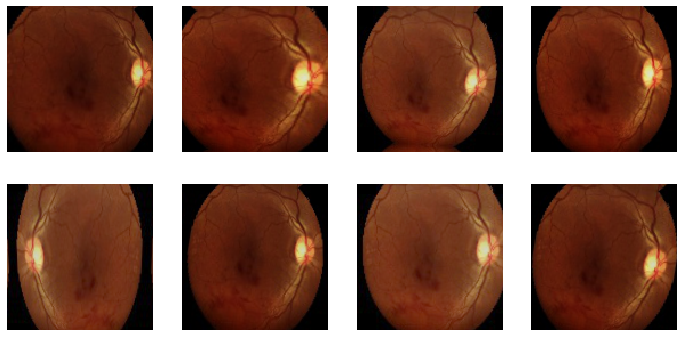

In [122]:
plots_f(2, 4, 12, 6)